In [1]:
import numpy as np
from keras.models import Model
from keras.layers import Input, merge, Convolution3D, MaxPooling3D, UpSampling3D, GlobalAveragePooling3D, Dense, Flatten, Dropout, Activation
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import ELU
from keras.optimizers import SGD, Adam, Nadam

from keras_tqdm import TQDMNotebookCallback

Using TensorFlow backend.


In [10]:
import data
import random
import scipy.ndimage.interpolation

vsize = np.asarray([32,32,32])

df_nodes = data.luna16_get_df_nodes() 
df_nodes = df_nodes[(df_nodes["diameter_mm"]>10)]

patient_ids = data.luna16_get_patient_ids()

X_nodules, diams = data.luna16_get_all_nodules(vsize, df_nodes)

def make_augmented(vsize, volume, X_nodules):
    idx = random.choice(range(len(X_nodules)))
    nodule = X_nodules[idx]
    # randomly flip or not flip each axis
    if random.choice([True, False]):
        nodule = nodule[::-1,:,:]
    if random.choice([True, False]):
        nodule = nodule[:,::-1,:]
    if random.choice([True, False]):
        nodule = nodule[:,:,::-1]
    mask = data.compose_make_mask(vsize, diam=diams[idx]+6, sigma=(diams[idx]+6)/8)
    volume_aug = data.compose_max2(volume, nodule, mask)
    return volume_aug

def sample_generator(vsize, patient_ids, X_nodules, diams):
    n = 0
    n_aug = 0

    central_mask = data.compose_make_mask(vsize, diam=6+6, sigma=(6+6)/8)
    
    while True:
        if n % 1000 == 0:
            try:
                pid = random.choice(patient_ids)
                image_ = data.luna16_get_image(pid)
                segmented_image_ = data.luna16_get_segmented_image(pid)

                image, segmented_image = image_, segmented_image_
                n+=1
                # segpack = np.packbits(segmented_image, axis=0)
                # info = data.luna16_get_info(pid)
            except Exception as e:
                #print(pid, repr(e))
                continue
            
        pos = np.asarray([ np.random.randint(k, image.shape[k] - vsize[k]) for k in range(3) ])
        segmented_volume = segmented_image[pos[0]:pos[0]+vsize[0], pos[1]:pos[1]+vsize[1], pos[2]:pos[2]+vsize[2]]
        if np.count_nonzero(segmented_volume) == 0:
            continue
#         segpack_volume = segpack[pos[0]//8:(pos[0]+vsize[0])//8, pos[1]:pos[1]+vsize[1], pos[2]:pos[2]+vsize[2]]
#         if np.count_nonzero(segpack_volume) == 0:
#            continue
        volume = image[pos[0]:pos[0]+vsize[0], pos[1]:pos[1]+vsize[1], pos[2]:pos[2]+vsize[2]]
#         overlap = np.mean(segmented_volume)
#         density = np.mean(volume)
        central_density = np.mean((volume+1000) * central_mask) / np.mean(central_mask) - 1000
    
        is_augmented = False
        if central_density < -500 and np.random.choice([True, False]):
            volume = make_augmented(vsize, volume, X_nodules)
            is_augmented = True
            n_aug += 1
            
        n+=1

        yield volume, is_augmented
        
def batch_generator(vsize, patient_ids, X_nodules, diams):
    gen = sample_generator(vsize, patient_ids, X_nodules, diams)
    batch_size = 64
    while True:
        X = np.zeros((batch_size, 32,32,32,1), dtype=np.float32)
        y = np.zeros((batch_size, 2), dtype=np.int)
        for n in range(batch_size):
            volume, is_augmented = next(gen)
            X[n,:,:,:,0] = volume
            if is_augmented:
                y[n,1] = 1
            else:
                y[n,0] = 1
        X = (X - X_mean)/X_std
        X = scipy.ndimage.interpolation.zoom(X, (1, 0.5, 0.5, 0.5, 1), order=1)
        yield X, y

In [115]:
gen = batch_generator(vsize, patient_ids, X_nodules, diams)

In [20]:
X, y = next(gen)

In [8]:
X_big = []
for n in range(100):
    X, y = next(gen)
    X_big.append(X)

/home/alex/anaconda3/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:571: RuntimeWarning: invalid value encountered in true_divide
  zoom = (numpy.array(input.shape) - 1) / zoom_div


In [25]:
X_mean = np.mean(X_big)
X_std = np.std(X_big)
print(X_mean, X_std)

-378.9 475.913


In [9]:
X_mean, X_std = -378.9, 475.913

In [12]:
vsize = (16, 16, 16)



def model3d(vsize, do_features=False):
    inputs = Input(vsize + (1,))
    sz = 48
    alpha = 1.5
    
    def conv3dparams(**replace_params):
        params = { 'activation':ELU(), 'border_mode':'valid', 'init': 'he_normal' }
        params.update(replace_params)
        return params

    x = Convolution3D(sz, 3, 3, 3, **conv3dparams())(inputs)
    x = BatchNormalization()(x)

    sz = int(sz * alpha)
    x = Convolution3D(sz, 3, 3, 3, **conv3dparams())(x)
    x = BatchNormalization()(x)
    x = Convolution3D(sz, 3, 3, 3, **conv3dparams())(x)
    x = BatchNormalization()(x)
    # x = MaxPooling3D(pool_size=(2, 2, 2))(x)

    sz = int(sz * alpha)
    x = Convolution3D(sz, 3, 3, 3, **conv3dparams())(x)
    x = BatchNormalization()(x)
    x = Convolution3D(sz, 3, 3, 3, **conv3dparams())(x)
    x = BatchNormalization()(x)
    # x = MaxPooling3D(pool_size=(2, 2, 2))(x)

    sz = int(sz * alpha)
    x = Convolution3D(sz, 3, 3, 3, **conv3dparams())(x)
    x = BatchNormalization()(x)
    x = Convolution3D(sz, 3, 3, 3, **conv3dparams())(x)
    x = BatchNormalization()(x)
    # x = MaxPooling3D(pool_size=(2, 2, 2))(x)

    sz = int(sz * alpha)
    # x = Convolution3D(sz, 3, 3, 3, **conv3dparams)(x)
    # x = Convolution3D(sz, 3, 3, 3, **conv3dparams)(x)
    # x = BatchNormalization()(x)

    x = Convolution3D(sz, 2, 2, 2, **conv3dparams())(x)
    x = BatchNormalization()(x)
    x = Convolution3D(sz, 1, 1, 1, **conv3dparams(border_mode='same'))(x)
    x = BatchNormalization()(x)
    x = Convolution3D(2, 1, 1, 1, **conv3dparams(activation='linear', border_mode='same'))(x)
    if not do_features:
        x = Flatten()(x)
        x = Activation('softmax')(x)

    model = Model(input=inputs, output=x)

    return model



In [13]:
model = model3d(vsize)
print(model.summary())


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 16, 16, 16, 1) 0                                            
____________________________________________________________________________________________________
convolution3d_1 (Convolution3D)  (None, 14, 14, 14, 48 1344        input_1[0][0]                    
____________________________________________________________________________________________________
batchnormalization_1 (BatchNorma (None, 14, 14, 14, 48 192         convolution3d_1[0][0]            
____________________________________________________________________________________________________
convolution3d_2 (Convolution3D)  (None, 12, 12, 12, 72 93384       batchnormalization_1[0][0]       
___________________________________________________________________________________________

In [16]:
#sgd = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='rmsprop')

batch_size=64

h = model.fit_generator(
    gen,
    10000,
    nb_epoch=100,
    verbose=0)

/home/alex/anaconda3/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:571: RuntimeWarning: invalid value encountered in true_divide
  zoom = (numpy.array(input.shape) - 1) / zoom_div
/home/alex/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:1573: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


In [17]:
h.history

{'acc': [0.97462181528662417,
  0.97551751592356684,
  0.98198646496815289,
  0.9845740445859873,
  0.98726114649681529,
  0.98666401273885351,
  0.98885350318471332,
  0.99094347133757965,
  0.9922372611464968,
  0.99144108280254772,
  0.99144108280254772,
  0.98915207006369432,
  0.99353105095541405,
  0.99253582802547768,
  0.99562101910828027,
  0.99422770700636942,
  0.99591958598726116,
  0.9921377388535032,
  0.99382961783439494,
  0.99522292993630568,
  0.99422770700636942,
  0.99492436305732479,
  0.99591958598726116,
  0.99641719745222934,
  0.99562101910828027,
  0.99572054140127386,
  0.99582006369426757,
  0.99472531847133761,
  0.99432722929936301,
  0.99611863057324845,
  0.99572054140127386,
  0.99591958598726116,
  0.99691480891719741,
  0.99532245222929938,
  0.99631767515923564,
  0.99701433121019112,
  0.99681528662420382,
  0.99522292993630568,
  0.99691480891719741,
  0.99621815286624205,
  0.99611863057324845,
  0.99651671974522293,
  0.99611863057324845,
  0.997

In [19]:
from pylab import *
%matplotlib inline

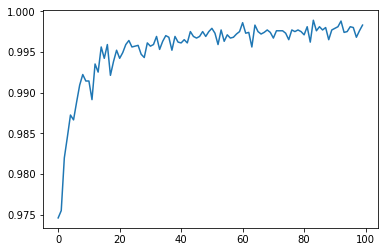

In [20]:
plot(h.history["acc"])

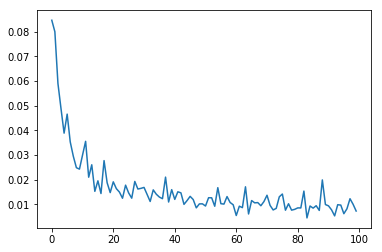

In [100]:
plot(h.history["loss"])

In [23]:
import data

In [24]:
pid = data.luna16_get_patient_ids()[0]

In [25]:
image = data.luna16_get_image(pid)

In [26]:
def preprocess(image):
    return (image - X_mean) / X_std

In [7]:
def preprocess2(image):
    image = np.clip(image, -1000, 100).astype(np.float32)
    return (image - np.mean(image)) / np.std(image)

In [21]:
model.save_weights('tmp.h5')

In [27]:
model2 = model3d((64,64,64), do_features=True)

In [28]:
# NOTE loading by_name=True fails, because the auto-generated layer names are counting up in keras for each layer class globally
# NOTE on the other hand plain loading works, since the missing top two layers don't have weights
model2.load_weights('tmp.h5')

In [29]:
model2.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 64, 64, 64, 1) 0                                            
____________________________________________________________________________________________________
convolution3d_11 (Convolution3D) (None, 62, 62, 62, 48 1344        input_2[0][0]                    
____________________________________________________________________________________________________
batchnormalization_10 (BatchNorm (None, 62, 62, 62, 48 192         convolution3d_11[0][0]           
____________________________________________________________________________________________________
convolution3d_12 (Convolution3D) (None, 60, 60, 60, 72 93384       batchnormalization_10[0][0]      
___________________________________________________________________________________________

In [33]:
def softmax(x):
    return np.exp(x - np.max(x)) / np.sum(np.exp(x - np.max(x)))

In [50]:
#pid = data.luna16_get_patient_ids()[0]
pid = df_nodes.iloc[0]["pid"]

In [52]:
image = data.luna16_get_image(pid)
image = preprocess(image)

In [53]:
import scipy.ndimage.interpolation
image_h = scipy.ndimage.interpolation.zoom(image, (0.5, 0.5, 0.5), order=1)

In [54]:
image_h.shape

(160, 142, 142)

In [55]:
def softmax_activations(x):
    r = x.reshape((-1,2))
    r_max = np.max(r, axis=-1)
    r_max = r_max[...,None]
    r_sum = np.sum(np.exp(r - r_max), axis=-1)
    r_sum = r_sum[...,None]
    p = np.exp(r - r_max) / r_sum
    p = p.reshape(x.shape)
    return p

In [81]:
def make_full_result(image):
    full_result = np.zeros((image.shape[0]+64, image.shape[1]+64, image.shape[2]+64, 2))
    s = 49
    d = 64
    for i in range(0, int(np.ceil(image.shape[0]/s))):
        for j in range(0, int(np.ceil(image.shape[1]/s))):
            for k in range(0, int(np.ceil(image.shape[2]/s))):
                input_ = image[i*s:i*s+d,j*s:j*s+d,k*s:k*s+d]
                if input_.shape != (d,d,d):
                    input_ = np.pad(input_, ((0, d-input_.shape[0]), (0, d-input_.shape[1]), (0, d-input_.shape[2])), 'constant')
                result = model2.predict(input_.reshape((1,d,d,d,1)), batch_size=1)
                full_result[i*s:(i+1)*s, j*s:(j+1)*s, k*s:(k+1)*s,:] = result
    return full_result

In [82]:
full_result = make_full_result(image_h)

In [83]:
full_result_p = softmax_activations(full_result)

In [27]:
from pylab import *
%matplotlib inline

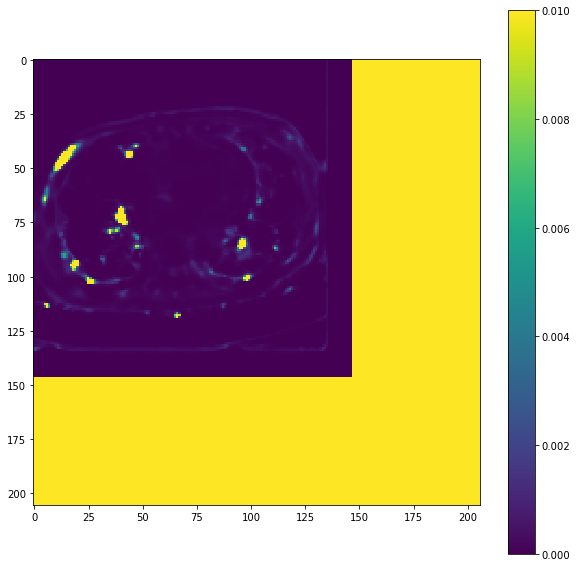

In [99]:
figure(figsize=(10,10))
imshow(full_result_p[65,:,:,1], vmax=0.01)
colorbar()

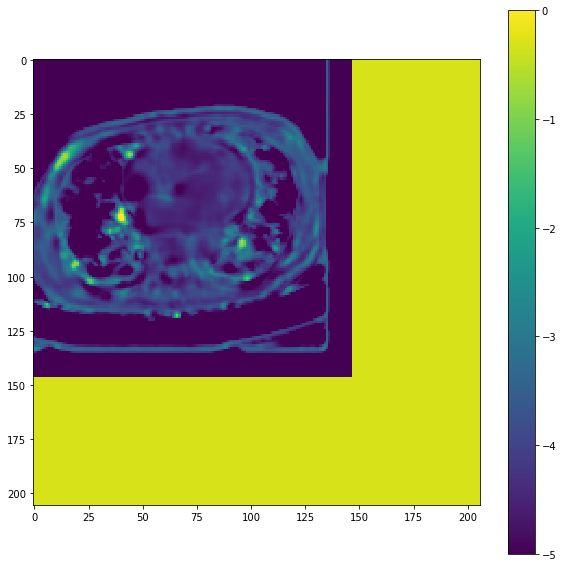

In [165]:
figure(figsize=(10,10))
imshow(np.log10(full_result_p[65,:,:,1]), vmax=0, vmin=-5)
colorbar()

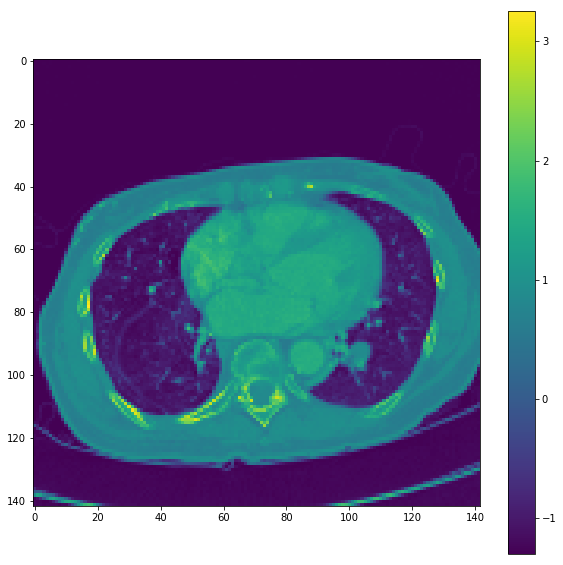

In [62]:
figure(figsize=(10,10))
imshow(image_h[65+8])
colorbar()

In [ ]:
patient_ids = data.luna16_get_patient_ids()
pid = [ x for x in patient_ids if in '5b41250' ][0]

In [59]:
image = np.load('5b412509bc40a3aeb3b5efef1fdfcfc9.npy', mmap_mode='r')
image = preprocess(image)

In [58]:
image.shape

(302, 360, 360)

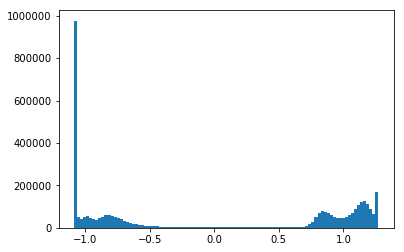

In [34]:
h = hist(image_h.ravel(), bins=100)

In [35]:
128 // 10

12

In [39]:
df_nodes

,seriesuid,coordX,coordY,coordZ,diameter_mm,pid
4,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,2.441547,172.464881,-405.493732,18.545150,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...
5,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,90.931713,149.027266,-426.544715,18.208570,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...
6,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,89.540769,196.405159,-515.073322,16.381276,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...
7,1.3.6.1.4.1.14519.5.2.1.6279.6001.100953483028...,81.509646,54.957219,-150.346423,10.362321,1.3.6.1.4.1.14519.5.2.1.6279.6001.100953483028...
8,1.3.6.1.4.1.14519.5.2.1.6279.6001.102681962408...,105.055792,19.825260,-91.247251,21.089619,1.3.6.1.4.1.14519.5.2.1.6279.6001.102681962408...
9,1.3.6.1.4.1.14519.5.2.1.6279.6001.104562737760...,-124.834262,127.247155,-473.064479,10.465854,1.3.6.1.4.1.14519.5.2.1.6279.6001.104562737760...
15,1.3.6.1.4.1.14519.5.2.1.6279.6001.106719103982...,-57.087180,74.259266,1790.494057,13.693566,1.3.6.1.4.1.14519.5.2.1.6279.6001.106719103982...
16,1.3.6.1.4.1.14519.5.2.1.6279.6001.107109359065...,-98.135977,-72.867792,-221.822772,18.127908,1.3.6.1.4.1.14519.5.2.1.6279.6001.107109359065...
25,1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524...,46.188539,48.402806,-108.578632,13.596471,1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524...
27,1.3.6.1.4.1.14519.5.2.1.6279.6001.110678335949...,-38.096020,-106.705434,-139.548467,13.683746,1.3.6.1.4.1.14519.5.2.1.6279.6001.110678335949...


In [143]:
tmp_false = np.zeros((10000,16,16,16,1))
n = 0
while n < 10000:
    x,y = next(gen)
    for i in range(x.shape[0]):
        if y[i,0] == 1:
            tmp_false[n] = x[i]
            n += 1
            
    

/home/alex/anaconda3/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:571: RuntimeWarning: invalid value encountered in true_divide
  zoom = (numpy.array(input.shape) - 1) / zoom_div


IndexError: index 10000 is out of bounds for axis 0 with size 10000

In [145]:
tmp = np.stack(X_nodules)[...,None]
tmp = preprocess(tmp)
tmp = scipy.ndimage.interpolation.zoom(tmp, (1, 0.5, 0.5, 0.5, 1), order=1)

p = model.predict(np.concatenate((tmp_false, tmp)))

/home/alex/anaconda3/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:571: RuntimeWarning: invalid value encountered in true_divide
  zoom = (numpy.array(input.shape) - 1) / zoom_div


In [147]:
y_true = np.zeros(p.shape[0])
y_true[10000:] = 1

In [140]:
np.count_nonzero(p[:,1]>0.50) / len(p[:,1])

0.19750195160031225

In [108]:
import random

In [113]:
vsize = np.asarray([32,32,32])


In [125]:
import sklearn.metrics

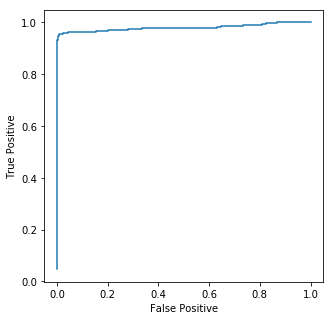

In [148]:
fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_true, p[:,1])
roc_auc = sklearn.metrics.auc(fpr, tpr)

figure(figsize=(5,5))
plot(fpr, tpr)
xlabel('False Positive')
ylabel('True Positive')

In [158]:
fpr[:40]

array([ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.0001,  0.0001,  0.0002,  0.0002,  0.0003,  0.0003,  0.0004,
        0.0004,  0.0005,  0.0005,  0.0006,  0.0006])

In [159]:
tpr[:40]

array([ 0.04626335,  0.0747331 ,  0.10676157,  0.1316726 ,  0.16014235,
        0.16370107,  0.18505338,  0.19572954,  0.20284698,  0.21352313,
        0.22775801,  0.23487544,  0.23843416,  0.25266904,  0.2633452 ,
        0.27046263,  0.27758007,  0.28469751,  0.29181495,  0.29893238,
        0.30960854,  0.32740214,  0.33807829,  0.35231317,  0.3594306 ,
        0.37010676,  0.3772242 ,  0.78647687,  0.78647687,  0.82562278,
        0.82562278,  0.84341637,  0.84341637,  0.86120996,  0.86120996,
        0.886121  ,  0.886121  ,  0.90035587,  0.90035587,  0.90747331])

In [130]:
np.max(p[:,1])

1.0

In [135]:
p[:,1]

array([  1.00000000e+00,   1.00000000e+00,   9.99999404e-01, ...,
         5.30295947e-05,   8.72668386e-01,   9.24380481e-01], dtype=float32)

In [ ]:
imshow(tmp_false[0])